#### If yfinance is not already installed, uncomment the code block below, and run

In [ ]:
#!pip install yfinance


In [119]:

import yfinance as yf  
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
from datetime import datetime
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
now = datetime.now()
now = str(now.year)+"-"+str(now.month)+"-"+str(now.day)
import requests
import pandas as pd
import arrow
import datetime
import os


### MACD
https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd


As its name implies, the MACD is all about the convergence and divergence of the two moving averages. Convergence occurs when the moving averages move towards each other. Divergence occurs when the moving averages move away from each other. The shorter moving average (12-day) is faster and responsible for most MACD movements. The longer moving average (26-day) is slower and less reactive to price changes in the underlying security.

The MACD line oscillates above and below the zero line, which is also known as the centerline. These crossovers signal that the 12-day EMA has crossed the 26-day EMA. The direction, of course, depends on the direction of the moving average cross. Positive MACD indicates that the 12-day EMA is above the 26-day EMA. Positive values increase as the shorter EMA diverges further from the longer EMA. This means upside momentum is increasing. Negative MACD values indicate that the 12-day EMA is below the 26-day EMA. Negative values increase as the shorter EMA diverges further below the longer EMA. This means downside momentum is increasing.

### Signal Line

Signal Line Crossovers
Signal line crossovers are the most common MACD signals. The signal line is a 9-day EMA of the MACD line. As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns. A bullish crossover occurs when the MACD turns up and crosses above the signal line. A bearish crossover occurs when the MACD turns down and crosses below the signal line. Crossovers can last a few days or a few weeks, depending on the strength of the move.

Due diligence is required before relying on these common signals. Signal line crossovers at positive or negative extremes should be viewed with caution. Even though the MACD does not have upper and lower limits, chartists can estimate historical extremes with a simple visual assessment. It takes a strong move in the underlying security to push momentum to an extreme. Even though the move may continue, momentum is likely to slow and this will usually produce a signal line crossover at the extremities. Volatility in the underlying security can also increase the number of crossovers.

In [120]:


def get_quote_data_by_minute(symbol='SPCE', data_range='1d', data_interval='1m'):
    res = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?range={data_range}&interval={data_interval}'.format(**locals()),verify=True)
    data = res.json()
    body = data['chart']['result'][0]    
    dt = datetime.datetime
    dt = pd.Series(map(lambda x: arrow.get(x).datetime.replace(tzinfo=None), body['timestamp']), name='Datetime')
    df = pd.DataFrame(body['indicators']['quote'][0], index=dt)
    dg = pd.DataFrame(body['timestamp'])    
    df = df.loc[:, ('open', 'high', 'low', 'close', 'volume')]
    df.dropna(inplace=True)     #removing NaN rows
    df.columns = ['OPEN', 'HIGH','LOW','CLOSE','VOLUME']    #Renaming columns in pandas
    df=df.reset_index()
    return df

In [121]:
def generate_stock_data(start_date,end_date,ticker):
    data = yf.download(ticker,start_date,end_date)
    
    data=data.reset_index()
    data=data.sort_values('Date')
    data=data[['Date','Open','Close','Volume','High','Low']]
    min_by_min = get_quote_data_by_minute(symbol=ticker,data_range='1d', data_interval='1m')
    min_by_min.columns=['Date','Open','High','Low','Close','Volume']
    update = min_by_min.loc[min_by_min.shape[0]-1]
    data=data.append(update)
    
    data['ticker']=ticker
    min_by_min.loc[min_by_min.shape[0]-1]
    #extract day of the week
    mapping = {0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    data['DOW'] = data['Date'].dt.dayofweek
    data['DOW_Mapped'] =data['DOW'].map(mapping)
    
    
    #calculate 7 day moving average with open and close
    data['5Day_Moving_Average_Close'] = data['Close'].rolling(window=5).mean()
    data['5Day_Moving_Average_Open'] = data['Open'].rolling(window=5).mean()
    
    #long ma 
    data['26Day_Moving_Average_Close'] = data['Close'].ewm(span=26).mean()
    
    #mid ma 
    data['12Day_Moving_Average_Close'] = data['Close'].ewm(span=12).mean()
    
    
    #short ma
    data['9Day_Moving_Average_Close'] = data['Close'].ewm(span=9).mean()
    
    
    #MACD
    data['MACD']=data['12Day_Moving_Average_Close']-data['26Day_Moving_Average_Close']
    
    
    
    #average the MACD to derive the signal line
    data['signal'] = data['MACD'].ewm(span=9).mean()
    
    
    # difference the macd from the sinal line to find the acceleration histogram
    data['hist'] = data['MACD'] - data['signal']
    

    
    #lag variables 1 DAY
    data['Close_Shift_1']=    data['Close'].shift(1)
    data['Open_Shift_1']=    data['Open'].shift(1)
    
    #lag variables 1 WEEK
    data['Close_Shift_5']=    data['Close'].shift(5)
    data['Open_Shift_5']=    data['Open'].shift(5)
    
    
    #prev_day_hi_or_low close
    data['Prev_Day_Compare_Close'] = data['Close']-data['Close_Shift_1']
    data['Prev_Day_Growth_Close'] = (data['Close']-data['Close_Shift_1'])/data['Close_Shift_1']
    
    
    #prev_day_hi_or_low open
    data['Prev_Day_Compare_Open'] = data['Open']-data['Open_Shift_1']
    data['Prev_Day_Growth_Open'] = (data['Open']-data['Open_Shift_1'])/data['Open_Shift_1']
    
    
    
    
    #prev_day_hi_or_low close
    data['Prev_Week_Compare_Close'] = data['Close']-data['Close_Shift_5']
    data['Prev_Week_Growth_Close'] = (data['Close']-data['Close_Shift_5'])/data['Close_Shift_5']
    
    
    #prev_day_hi_or_low open
    data['Prev_Week_Compare_Open'] = data['Open']-data['Open_Shift_5']
    data['Prev_Week_Growth_Open'] = (data['Open']-data['Open_Shift_5'])/data['Open_Shift_5']
    
    
    
    
    data=data.iloc[5:]
    data

    
    return data




[*********************100%***********************]  1 of 1 completed


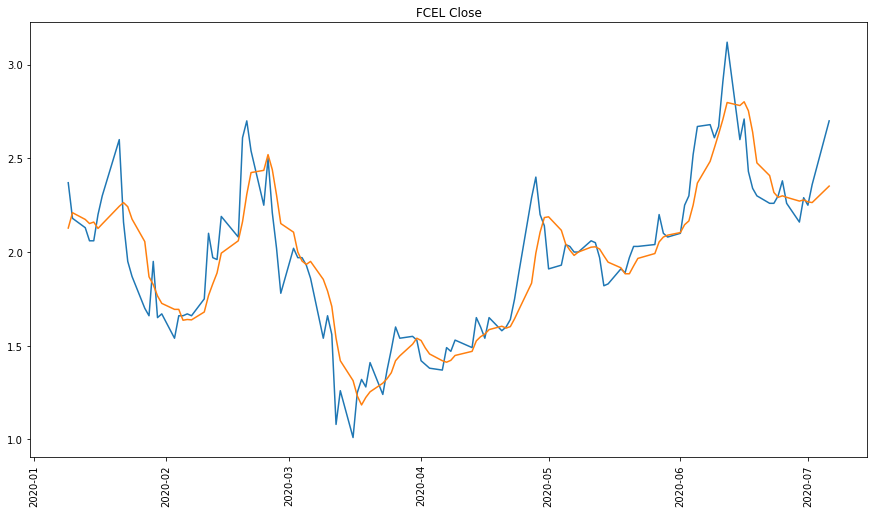

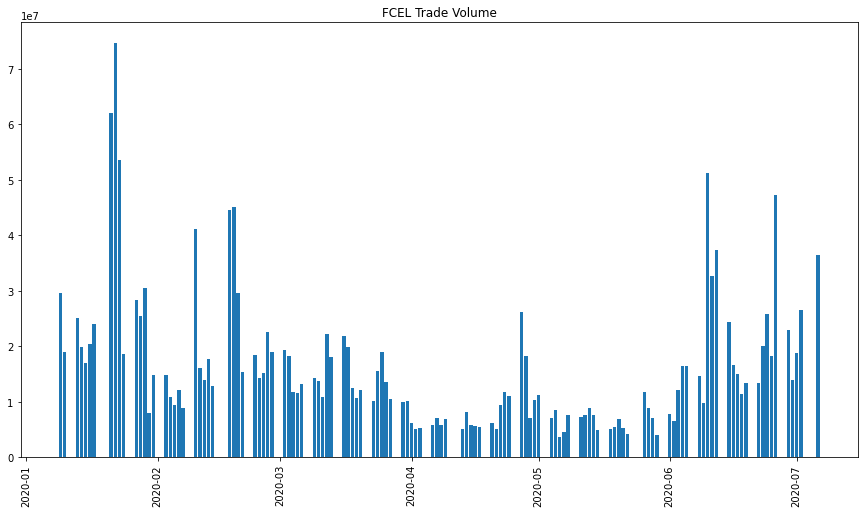

In [122]:
start = '2020-01-01'
SDOW = generate_stock_data(start,now,ticker)

plt.figure(figsize=(15,8))
plt.title('{} Close'.format(ticker))

plt.plot(SDOW['Date'],SDOW['Open'])

plt.plot(SDOW['Date'],SDOW['5Day_Moving_Average_Open'])

plt.xticks(rotation=90)
plt.show()
#----------------------------------------------

plt.figure(figsize=(15,8))
plt.title('{} Trade Volume'.format(ticker))


plt.bar(SDOW['Date'],SDOW['Volume'])

plt.xticks(rotation=90)
plt.show()


In [123]:
import datapackage

data_url = 'https://datahub.io/core/nasdaq-listings/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        NASDAQ = pd.read_csv(resource.descriptor['path'])
        

In [126]:
import tqdm
all_data = []

for sym in NASDAQ['Symbol']:
    try:
        curr = generate_stock_data(start,now,sym)
        all_data.append(curr)
    except:
        print('{} is delisted'.format(sym))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAVL: No data found for this date range, symbol may be delisted
AAVL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ABAC: No data found for this date range, symbol may be delisted
ABAC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ABAX: No data

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFFX: No data found for this date range, symbol may be delisted
AFFX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFOP: No data found for this date range, symbol may be delisted
AFOP is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AFSI: No data found for this date range, symbol may be delisted
AFSI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AGII: No data found for this date range, symbol may be delisted
AGII is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AGIIL: No data

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ANCB: No data found for this date range, symbol may be delisted
ANCB is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ANCI: No data found for this date range, symbol may be delisted
ANCI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ANCX: No data found for this date range, symbol may be delisted
ANCX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ATHN: No data found for this date range, symbol may be delisted
ATHN is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ATML: No data found for this date range, symbol may be delisted
ATML is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ATNY: No data found for this date range, symbol may be delisted
ATNY is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BHBK: No data found for this date range, symbol may be delisted
BHBK is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTUI: No data found for this date range, symbol may be delisted
BTUI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BUR: No data found for this date range, symbol may be delisted
BUR is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BVA: No data found for this date range, symbol may be delisted
BVA is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Fa

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CBNJ: No data found for this date range, symbol may be delisted
CBNJ is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CBRX: No data found for this date range, symbol may be delisted
CBRX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CBST: No data found for this date range, symbol may be delisted
CBST is delisted
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CIFC: No data found for this date range, symbol may be delisted
CIFC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CIMT: No data found for this date range, symbol may be delisted
CIMT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CISAW: No data found, symbol may be delisted
CISAW is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CISG: No data found for this date range, symbol may be delisted
CISG is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- COOL: No data found for this date range, symbol may be delisted
COOL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CORI: No data found for this date range, symbol

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CTRP: No data found, symbol may be delisted
CTRP is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CTRX: No data found for this date range, symbol may be delisted
CTRX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CTWS: No data found, symbol may be delisted
CTWS is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CU: No data found for this date range, symbol may be delisted
CU is delisted
[*********************100%***********************]  1 of 1 completed
[**********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DOVR: No data found for this date range, symbol may be delisted
DOVR is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DPRX: No data found for this date range, symbol may be delisted
DPRX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DRAM: No data found for this date range, symbol may be delisted
DRAM is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EGRW: No data found for this date range, symbol may be delisted
EGRW is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EGT: No data found for this date range, symbol may be delisted
EGT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ELNK: No data found for this date range, symbol may be delisted
ELNK is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ELON: No data found for this date range, symbol may be delisted
ELON is delisted
[*********************100%************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EVEP: No data found for this date range, symbol may be delisted
EVEP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EVLV: No data found, symbol may be delisted
EVLV is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EVRY: No data found for this date range, symbol may be delisted
EVRY is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EXA: No data found for this date range, symbol may be delisted
EXA is delisted
[*********************100%***********************]  1 of 1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FLML: No data found for this date range, symbol may be delisted
FLML is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FXCB: No data found for this date range, symbol may be delisted
FXCB is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FXEN: No data found for this date range, symbol may be delisted
FXEN is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FXENP: No data found, symbol may be delisted
FXENP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GAI: No data found for this date range, symbol may be delisted
GAI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GOODO: No data found, symbol may be delisted
GOODO is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GOODP: No data found, symbol may be delisted
GOODP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GPIC: No data found, symbol may be delisted
GPIC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HFBC: No data found, symbol may be delisted
HFBC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HFFC: No data found for this date range, symbol may be delisted
HFFC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HIIQ: No data found, symbol may be delisted
HIIQ is delisted
[*********************100%***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IDSA: No data found, symbol may be delisted
IDSA is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IDSY: No data found, symbol may be delisted
IDSY is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IDTI: No data found for this date range, symbol may be delisted
IDTI is delisted
[*********************100%***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IPXL: No data found for this date range, symbol may be delisted
IPXL is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IQNT: No data found for this date range, symbol may be delisted
IQNT is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IRDMB: No data found, symbol may be delisted
IRDMB is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IRDMZ: No data found, symbol may be delisted
IRDMZ is delisted
[**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KCAP: No data found for this date range, symbol may be delisted
KCAP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KERX: No data found for this date range, symbol may be delisted
KERX is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KEYW: No data found, symbol may be delisted
KEYW is delisted
[*********************100%***********************]  1 of 1 completed
[********************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LINE: No data found for this date range, symbol may be delisted
LINE is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LION: No data found, symbol may be delisted
LION is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LIOX: No data found for this date range, symbol may be delisted
LIOX is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LIQD: No data found for this date range, symbol may be delisted
LIQD is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MBFI: No data found for this date range, symbol may be delisted
MBFI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MBFIP: No data found for this date range, symbol may be delisted
MBFIP is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MBLX: No data found for this date range, symbol may be delisted
MBLX is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MBRG: No data found for this date range, symbol may be delisted
MBRG is delisted
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MITL: No data found for this date range, symbol may be delisted
MITL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MKTO: No data found for this date range, symbol may be delisted
MKTO is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MLNK: No data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NANO: No data found, symbol may be delisted
NANO is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NATL: No data found for this date range, symbol may be delisted
NATL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NAVG: No data found, symbol may be delisted
NAVG is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NVDQ: No data found for this date range, symbol may be delisted
NVDQ is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NVEEW: No data found for this date range, symbol may be delisted
NVEEW is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NVGN: No data found for this date range, symbol may be delisted
NVGN is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NVSL: No data found for this date range, symbol may be delisted
NVSL is delisted
[*********************100%********

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OSHC: No data found for this date range, symbol may be delisted
OSHC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OSIR: No data found, symbol may be delisted
OSIR is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OSM: No data found for this date range, symbol may be delisted
OSM is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PETM: No data found for this date range, symbol may be delisted
PETM is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PETX: No data found, symbol may be delisted
PETX is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 o

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PRXI: No data found for this date range, symbol may be delisted
PRXI is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PRXL: No data found for this date range, symbol may be delisted
PRXL is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PSAU: No data found for this date range, symbol may be delisted
PSAU is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PSBH: No data found for this date range, symbol may be delisted
PSBH is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QUNR: No data found for this date range, symbol may be delisted
QUNR is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QVCA: No data found for this date range, symbol may be delisted
QVCA is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QVCB: No data found, symbol may be delisted
QVCB is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[********************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ROIQW: No data found, symbol may be delisted
ROIQW is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ROKA: No data found for this date range, symbol may be delisted
ROKA is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ROSG: No data found for this date range, symbol may be delisted
ROSG is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ROVI: No data found for this date range, symbol may be delisted
ROVI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SCSS: No data found for this date range, symbol may be delisted
SCSS is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SEMI: No data found for this date range, symbol may be delisted
SEMI is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SLXP: No data found for this date range, symbol may be delisted
SLXP is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SMAC: No data found, symbol may be delisted
SMAC is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SMACR: No data found, symbol may be delisted
SMACR is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SMACU: No data found, symbol may be delisted
SMACU is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SRSC: No data found, symbol may be delisted
SRSC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SSFN: No data found, symbol may be delisted
SSFN is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SSH: No data found for this date range, symbol may be delisted
SSH is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SSRG: No data found f

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TECU: No data found for this date range, symbol may be delisted
TECU is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TSRA: No data found for this date range, symbol may be delisted
TSRA is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TSRE: No data found for this date range, symbol may be delisted
TSRE is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TSRO: No data found for this date range, symbol may be delisted
TSRO is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TST: No data found, symbol may be delisted
TST is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TSYS: No data found for this date ra

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- USTR: No data found for this date range, symbol may be delisted
USTR is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UTEK: No data found for this date range, symbol may be delisted
UTEK is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UTIW: No data found for this date range, symbol may be delisted
UTIW is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VA: No data found for this date range, symbol may be delisted
VA is delisted
[*********************100%**************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VTAE: No data found for this date range, symbol may be delisted
VTAE is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VTL: No data found for this date range, symbol may be delisted
VTL is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VTSS: No data found for this date range, symbol may be delisted
VTSS is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WSFSL: No data found, symbol may be delisted
WSFSL is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WSTC: No data found for this date range, symbol may be delisted
WSTC is delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WTFCW: No data found, symbol may be delisted
WTFCW is delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WTSL: No data found for this date range, symbol may be delisted
WTSL is delisted
[**

In [189]:
NASDAQ_df = pd.concat(all_data)

In [190]:
from datetime import datetime


In [260]:
def upward_trending_stocks(nasdaq_data,end_date,start_date_lb=10,upward=True):
    if upward==True:
        start_date = datetime.today() - timedelta(days=start_date_lb)
        yesterday = datetime.today() - timedelta(days=1)
        start_date = str(start_date.year)+"-"+str(start_date.month)+"-"+str(start_date.day)
        yesterday = str(yesterday.year)+"-"+str(yesterday.month)+"-"+str(yesterday.day)

        nasdaq_data = nasdaq_data[(nasdaq_data['Date']>=start_date)&(nasdaq_data['Date']<=end_date)]

        save_columns = ['Date','ticker','MACD','signal','Close']
        sort_values = []
        for i in range(1,6):
            if i==1:
                nasdaq_data['MACD_Shift_{}Day'.format(i)]=nasdaq_data.groupby('ticker')['MACD'].shift(i)

                nasdaq_data['Cross_Over_{}_Days'.format(i)] = [1 if x>0 and y<0 else 0 for x,y in zip(nasdaq_data['MACD'],nasdaq_data['MACD_Shift_{}Day'.format(i)])]
                save_columns.append('Cross_Over_{}_Days'.format(i))
                sort_values.append('Cross_Over_{}_Days'.format(i))
            else:
                nasdaq_data['MACD_Shift_{}Day'.format(i)]=nasdaq_data.groupby('ticker')['MACD'].shift(i)

                nasdaq_data['Cross_Over_{}_Days'.format(i)] = [1 if x>0 and y<0 else 0 for x,y in zip(nasdaq_data['MACD_Shift_{}Day'.format(i-1)],nasdaq_data['MACD_Shift_{}Day'.format(i)])]
                save_columns.append('Cross_Over_{}_Days'.format(i))
                sort_values.append('Cross_Over_{}_Days'.format(i))

                
                

        Top_Shifts = nasdaq_data[save_columns]

        new_frame = []
        for c_ in sort_values:
            curr_shift = Top_Shifts[Top_Shifts[c_]==1]
            curr_shift=curr_shift[['Date','ticker','MACD','signal','Close',c_]]
            curr_shift=curr_shift.rename(columns={c_:'Upward'})
            curr_shift['Day']= '{} Days Ago'.format(c_.split('_')[2])
            new_frame.append(curr_shift)

        Final_Shifts = pd.concat(new_frame)
        Final_Shifts=Final_Shifts[Final_Shifts['Date']==yesterday]
        Final_Shifts=Final_Shifts.reset_index(drop=True)
        Final_Shifts=Final_Shifts[Final_Shifts['']]
        return (nasdaq_data,Final_Shifts)
    else:
        start_date = datetime.today() - timedelta(days=start_date_lb)
        yesterday = datetime.today() - timedelta(days=1)
        start_date = str(start_date.year)+"-"+str(start_date.month)+"-"+str(start_date.day)
        yesterday = str(yesterday.year)+"-"+str(yesterday.month)+"-"+str(yesterday.day)

        nasdaq_data = nasdaq_data[(nasdaq_data['Date']>=start_date)&(nasdaq_data['Date']<=end_date)]

        save_columns = ['Date','ticker','MACD','signal','Close']
        sort_values = []
        for i in range(1,6):
            if i==1:
                nasdaq_data['MACD_Shift_{}Day'.format(i)]=nasdaq_data.groupby('ticker')['MACD'].shift(i)

                nasdaq_data['Cross_Over_{}_Days'.format(i)] = [1 if x<0 and y>0 else 0 for x,y in zip(nasdaq_data['MACD'],nasdaq_data['MACD_Shift_{}Day'.format(i)])]
                save_columns.append('Cross_Over_{}_Days'.format(i))
                sort_values.append('Cross_Over_{}_Days'.format(i))
            else:
                nasdaq_data['MACD_Shift_{}Day'.format(i)]=nasdaq_data.groupby('ticker')['MACD'].shift(i)

                nasdaq_data['Cross_Over_{}_Days'.format(i)] = [1 if x<0 and y>0 else 0 for x,y in zip(nasdaq_data['MACD_Shift_{}Day'.format(i-1)],nasdaq_data['MACD_Shift_{}Day'.format(i)])]
                save_columns.append('Cross_Over_{}_Days'.format(i))
                sort_values.append('Cross_Over_{}_Days'.format(i))
                
                
                

        Top_Shifts = nasdaq_data[save_columns]

        new_frame = []
        for c_ in sort_values:
            curr_shift = Top_Shifts[Top_Shifts[c_]==1]
            curr_shift=curr_shift[['Date','ticker','MACD','signal','Close',c_]]
            curr_shift=curr_shift.rename(columns={c_:'Upward'})
            curr_shift['Day']= '{} Days Ago'.format(c_.split('_')[2])
            new_frame.append(curr_shift)

        Final_Shifts = pd.concat(new_frame)
        Final_Shifts=Final_Shifts[Final_Shifts['Date']==yesterday]
        Final_Shifts=Final_Shifts.reset_index(drop=True)
        return (nasdaq_data,Final_Shifts)
        




In [261]:
CurrNas_up,TopShifts_up = upward_trending_stocks(NASDAQ_df,now,10,upward=True)


/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [262]:
CurrNas_down,TopShifts_down = upward_trending_stocks(NASDAQ_df,now,10,upward=False)


/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [263]:
TopShifts_up[TopShifts_up['Day']=='1 Days Ago'].sort_values('Close')

,Date,ticker,MACD,signal,Close,Upward,Day
23,2020-07-06,SIXD,0.000370,-0.001101,0.020000,1,1 Days Ago
11,2020-07-06,GULTU,0.000072,-0.000148,0.022000,1,1 Days Ago
28,2020-07-06,WPRT,0.002144,0.000359,1.400000,1,1 Days Ago
2,2020-07-06,CLRB,0.010689,-0.024298,1.490000,1,1 Days Ago
16,2020-07-06,NURO,0.003732,-0.026861,2.120000,1,1 Days Ago
5,2020-07-06,CRNT,0.001504,-0.016074,2.290000,1,1 Days Ago
9,2020-07-06,DRAD,0.000997,-0.028903,2.810000,1,1 Days Ago
17,2020-07-06,PACB,0.024947,0.008852,3.930000,1,1 Days Ago
6,2020-07-06,CTG,0.004825,0.009763,4.240000,1,1 Days Ago
24,2020-07-06,TESS,0.002436,-0.041821,5.460000,1,1 Days Ago


In [266]:
TopShifts_up[TopShifts_up['Day']=='2 Days Ago'].sort_values('Close')

,Date,ticker,MACD,signal,Close,Upward,Day
35,2020-07-06,CALI,0.001809,-0.000325,0.050000,1,2 Days Ago
34,2020-07-06,BSPM,-0.000252,0.001152,0.070000,1,2 Days Ago
39,2020-07-06,ESMC,-0.001758,-0.001483,0.120000,1,2 Days Ago
41,2020-07-06,FSAM,0.003482,-0.001093,0.300000,1,2 Days Ago
37,2020-07-06,DARA,0.001912,0.000244,0.390000,1,2 Days Ago
55,2020-07-06,TORM,0.010927,-0.014299,1.100000,1,2 Days Ago
38,2020-07-06,ENG,0.008666,0.005162,1.110000,1,2 Days Ago
43,2020-07-06,GIFI,0.014312,0.004727,3.210000,1,2 Days Ago
32,2020-07-06,ATEC,0.000920,0.048712,4.680000,1,2 Days Ago
31,2020-07-06,AMAG,0.056930,-0.027449,8.280000,1,2 Days Ago


In [252]:
TopShifts_down.to_csv('/Users/sheenmccullough/Documents/StockEval/data/downward_trend_{}_.csv'.format(now),index=False)
TopShifts_up.to_csv('/Users/sheenmccullough/Documents/StockEval/data/upward_trend_{}_.csv'.format(now),index=False)

[*********************100%***********************]  1 of 1 completed


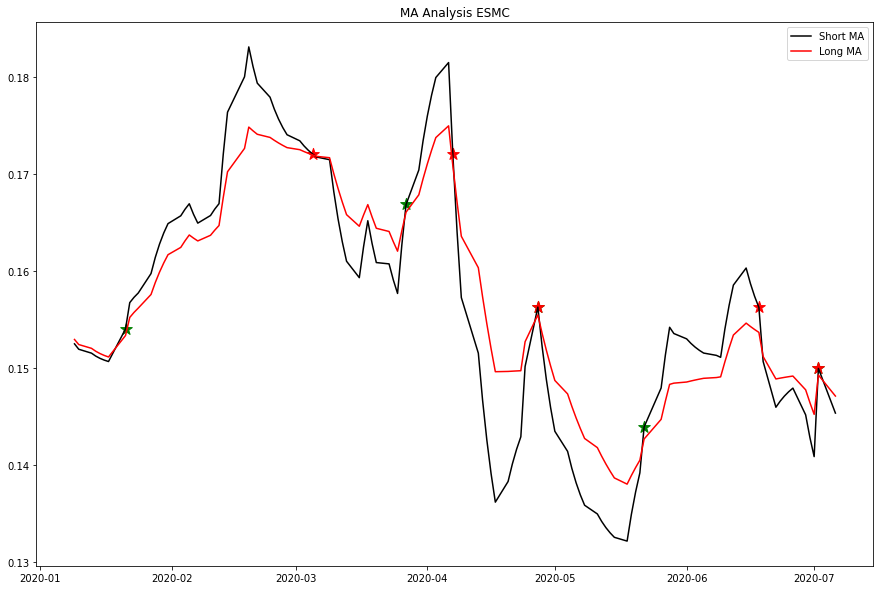

In [267]:

ticker='ESMC'
start = '2020-01-01'
SDOW = generate_stock_data(start,now,ticker)




plt.figure(figsize=(15,10))
plt.plot(SDOW['Date'],SDOW['12Day_Moving_Average_Close'],label='Short MA',color='k')
plt.plot(SDOW['Date'],SDOW['26Day_Moving_Average_Close'],label='Long MA',color='r')


for values in range(len(SDOW)):
    if values!=0:
        if SDOW['MACD'].iloc[values]<0:
            if SDOW['MACD'].iloc[values-1]>0:
                plt.scatter(SDOW['Date'].iloc[values-1],SDOW['12Day_Moving_Average_Close'].iloc[values-1],marker='*',
                       color='red',s=150)
                
    if SDOW['MACD'].iloc[values]>=0:
        if SDOW['MACD'].iloc[values-1]<0:
            plt.scatter(SDOW['Date'].iloc[values],SDOW['12Day_Moving_Average_Close'].iloc[values],marker='*',
                       color='green',s=150)
            
            
plt.title('MA Analysis {}'.format(ticker))

plt.legend()
plt.show()

#### red star siginal a downward trend & green stars signal an upward trend

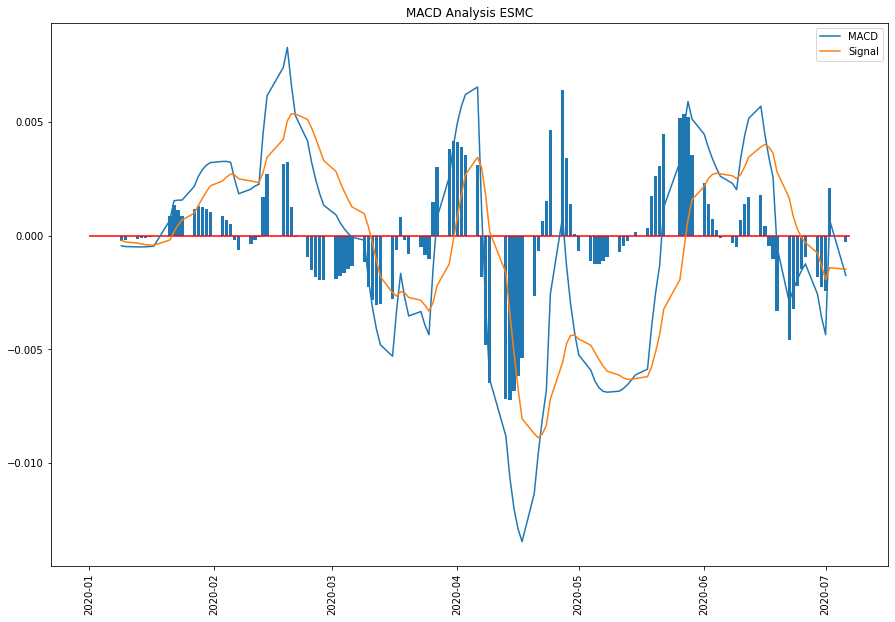

In [268]:
plt.figure(figsize=(15,10))
plt.title('MACD Analysis {}'.format(ticker))
plt.plot(SDOW['Date'],SDOW['MACD'],label='MACD')
plt.plot(SDOW['Date'],SDOW['signal'],label='Signal')
plt.hlines(0,start,now,'r')
plt.bar(SDOW['Date'],SDOW['hist'])
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [9]:
min_by_min = get_quote_data_by_minute(symbol="WORK",data_range='1d', data_interval='1m')
min_by_min.tail(20)

,Datetime,OPEN,HIGH,LOW,CLOSE,VOLUME
70,2020-07-06 14:41:00,31.205000,31.219999,31.184000,31.219999,24990.0
71,2020-07-06 14:42:00,31.215000,31.330000,31.215000,31.330000,131330.0
72,2020-07-06 14:43:00,31.325001,31.389999,31.309999,31.385900,42823.0
73,2020-07-06 14:44:00,31.389999,31.440001,31.385000,31.430000,0.0
74,2020-07-06 14:45:00,31.434999,31.495001,31.434999,31.485001,81339.0
75,2020-07-06 14:46:00,31.485001,31.555000,31.475000,31.540001,104752.0
76,2020-07-06 14:47:00,31.540001,31.540001,31.485001,31.520000,28610.0
77,2020-07-06 14:48:00,31.514999,31.540001,31.500000,31.530001,26914.0
78,2020-07-06 14:49:00,31.535000,31.549999,31.530001,31.530001,27522.0
79,2020-07-06 14:50:00,31.520000,31.540001,31.495001,31.502001,31386.0


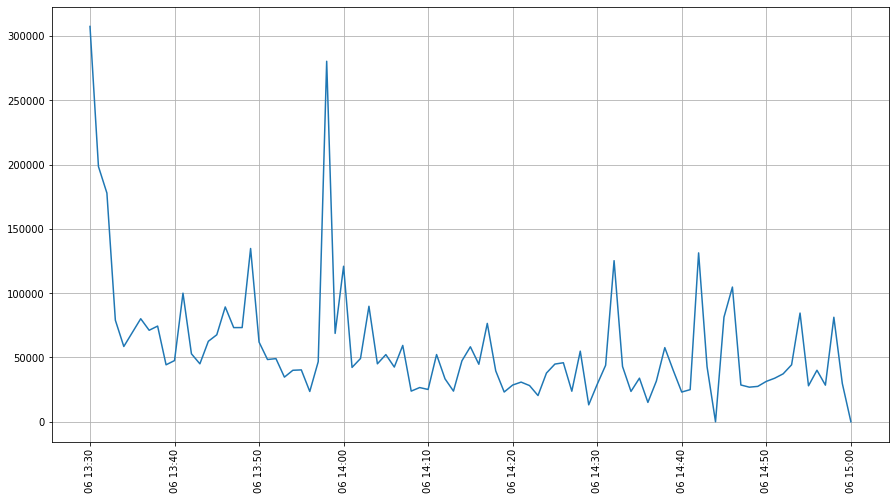

In [10]:
plt.figure(figsize=(15,8))

plt.plot(min_by_min['Datetime'],min_by_min['VOLUME'])


plt.xticks(rotation=90)
plt.grid(True)
plt.show()

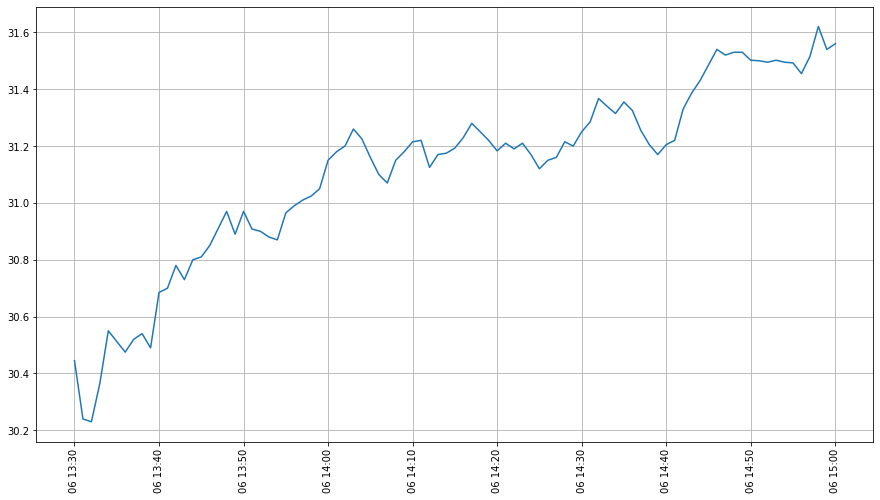

In [11]:
plt.figure(figsize=(15,8))

plt.plot(min_by_min['Datetime'],min_by_min['CLOSE'])


plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [ ]:
# For data manipulation
import pandas as pd

# To extract fundamental data
from bs4 import BeautifulSoup as bs
import requests

In [ ]:
import requests, re, json, pprint
import numpy as np
p = re.compile(r'root\.App\.main = (.*);')
tickers = ['PLUG','FCEL']
results = {}

with requests.Session() as s:

    for ticker in tickers:
        r = s.get('https://finance.yahoo.com/quote/{}/key-statistics?p={}'.format(ticker,ticker))
        data = json.loads(p.findall(r.text)[0])
        key_stats = data['context']['dispatcher']['stores']['QuoteSummaryStore']
        results.setdefault(ticker,[])
        results[ticker]
        try:
            res = {'EnterPrise Value' :key_stats['defaultKeyStatistics']['enterpriseValue']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'EnterPrise Value':np.nan})
            
        try:
            res = {'Trailing P/E' : key_stats['summaryDetail']['trailingPE']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'Trailing P/E':np.nan})
            
        try:
            res = {'Forward P/E' : key_stats['summaryDetail']['forwardPE']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'Forward P/E':np.nan})
            
            
        try:
            res = {'PEG Ratio (5 yr expected)' : key_stats['defaultKeyStatistics']['pegRatio']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({'PEG Ratio (5 yr expected)':np.nan})
            
        try:
            res = {'Return on Assets' : key_stats['financialData']['returnOnAssets']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({"Return on Assets":np.nan})
            
        try:
            res = {'Quarterly Revenue Growth' : key_stats['financialData']['revenueGrowth']['fmt']}
            results[ticker].append(res)
        except:
            results[ticker].append({"Quarterly Revenue Growth":np.nan})
            
        res = {'Company' : ticker}
        results[ticker].append(res)    
            
        

In [ ]:
import requests, re, json, pprint
import numpy as np
p = re.compile(r'root\.App\.main = (.*);')
tickers = ['PLUG','FCEL']
q_results = {}
main_keys = ['trailingPsRatio', 
             'quarterlyPbRatio', 
             'quarterlyForwardPeRatio',
             'quarterlyMarketCap', 
             'quarterlyPeRatio', 
             'trailingMarketCap',
             'trailingEnterprisesValueEBITDARatio',
             'quarterlyEnterprisesValueEBITDARatio', 
             'trailingForwardPeRatio', 
             'trailingEnterpriseValue',
             'trailingPeRatio', 
             'quarterlyEnterprisesValueRevenueRatio', 
             'quarterlyPsRatio', 
             'trailingEnterprisesValueRevenueRatio', 
             'quarterlyPegRatio', 
             'trailingPbRatio',
             'quarterlyEnterpriseValue', 
             'trailingPegRatio', 
             'timestamp']

with requests.Session() as s:

    for ticker in tickers:
        r = s.get('https://finance.yahoo.com/quote/{}/key-statistics?p={}'.format(ticker,ticker))
        data = json.loads(p.findall(r.text)[0])
        
        key_stats = data['context']['dispatcher']['stores']['QuoteTimeSeriesStore']
        
        q_results.setdefault(ticker,[])
        for mk in main_keys:
            try:
                res = {mk: key_stats['timeSeries'][mk][1]['reportedValue']['raw']}
                
                q_results[ticker].append(res)
            except:
                q_results[ticker].append({mk:np.nan})
            
        res = {'Company' : ticker}
        q_results[ticker].append(res)  
            
                
                
                
        

In [ ]:
finstats = {}

for k in results.keys():
    c = results[k]
    for ix in range(len(c)):
        for key,val in  c[ix].items():
            finstats.setdefault(key,[])
            finstats[key].append(val)
    
            

In [ ]:
fstat = pd.DataFrame(finstats)

In [ ]:
finstats_q = {}

for k in q_results.keys():
    c = q_results[k]
    for ix in range(len(c)):
        for key,val in  c[ix].items():
            finstats_q.setdefault(key,[])
            finstats_q[key].append(val)
    

In [ ]:
fstatsq = pd.DataFrame(finstats_q)

In [ ]:
full_df = pd.merge(fstat,fstatsq,on='Company')
full_df_transpose=full_df.T
full_df_transpose.columns = list(full_df['Company'])

In [ ]:
full_df_transpose